# DQN Reinforced Learning

Author: Rafael Godoy

LinkedIn: https://www.linkedin.com/in/Rafael-Godoy-ML-Eng

Github: https://github.com/RafaelSilvaGodoy


This notebook will show a **Reinforced Learning** method called **DQN**. An agent is trained (green) by playing against Atari (orange) on a ping-pong game.

The ping-pong game ends when the first player reaches 21 points.

This notebook is prepared to run on Colab.

The Atari ping-pong enviroment can be found on: https://github.com/openai/gym


In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from PIL import Image
from random import random, randrange, randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K

In [2]:
ENV_NAME = 'PongDeterministic-v4'      # Environment Name
RENDER_VIDEO = False                   # Whether to render video during training
IMG_SIZE = (105, 80)                   # Image Size after preprocessing (height, width)
NET_INPUT_SHAPE = (105, 80, 3)         # Network Input Shape
MAX_EPISODES = 201                     # Maximum Number of Episodes to be simulated
MAX_TIMESTEPS_PER_EPISODE = np.inf     # Maximum number of timsteps in a single episode
EXPERIENCE_REPLAY_SIZE = 1.5e5         # Maximum Size of Experience Replay Memory
EXPERIENCE_START_SIZE = 50e3           # Minimum number of random transitions to store before training
MINIBATCH_SIZE = 32                    # Size of minibatch sampled during training
TARGET_NETWORK_UPDATE_FREQ = 1e3       # Rate at which DQN_target is synchronized with DQN
LEARNING_RATE = 0.00025                # Learning rate used during training
DISCOUNT_FACTOR = 0.99                 # MDP discount factor gamma
DROPOUT_PROB = 0.1                     # Dropout rate for the DQN
INITIAL_EPSILON = 1                    # Initial value of epsilon for epsilon-greedy policy
EPSILON_DECREASE_RATE = 5e-6           # Epsilon decrease rate
MIN_EPSILON = 0.1                      # Minimum epsilon value to guarantee minimum exploration later

In [3]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')

('Roms.rar', <http.client.HTTPMessage at 0x7f6fadc1d6d0>)

In [4]:
%%capture
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

In [5]:
# Create Environment
env = gym.make('PongDeterministic-v4')

In [7]:
# Observation Space
print("Observation Sapce: ", env.observation_space.shape)
print("")

# Action Space
print("Action space: ", env.action_space)
print("")

# Action Meanings
print('Action Meanings: ',env.unwrapped.get_action_meanings())

Observation Sapce:  (210, 160, 3)

Action space:  Discrete(6)

Action Meanings:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Auxiliar Functions

In [8]:
# ImagePreprocessor

class ImagePreprocessor(gym.Wrapper):
    
    def __init__(self, env, height, width, grayscale=True):
        
        super().__init__(env)
        
        self.height = int(height)
        self.width = int(width)
        self.grayscale = bool(grayscale)
        
        # check original shape / dtype
        shape = self.env.observation_space.shape
        dtype = self.env.observation_space.dtype
        assert len(shape) == 3, "bad shape: {}".format(shape)
        assert shape[2] == 3, "bad shape: {}".format(shape)
        assert dtype == 'uint8', "bad dtype: {}".format(dtype)
        
        # update observation space
        if self.grayscale:
            shape = (self.height, self.width)
        else:
            shape = (self.height, self.width, shape[2])
        self.observation_space = gym.spaces.Box(
            shape=shape, low=0, high=255, dtype='uint8')


    def _preprocess_frame(self, s):
        img = Image.fromarray(s)
        if self.grayscale:
            img = img.convert('L')
        img = img.resize((self.width, self.height))
        return np.array(img)


    def reset(self):
        self._s_orig = self.env.reset()
        s = self._preprocess_frame(self._s_orig)   # shape: [h, w]
        return s


    def step(self, a):
        self._s_next_orig, r, done, info = self.env.step(a)
        s_next = self._preprocess_frame(self._s_next_orig)
        return s_next, r, done, info

In [9]:
# FrameStacker

class FrameStacker(gym.Wrapper):
    
    def __init__(self, env, num_frames=4):
        
        super().__init__(env)

        self.num_frames = int(num_frames)
        
        s = self.env.observation_space.sample()
        if s.ndim == 2:
            self._perm = (1, 2, 0)
        elif s.ndim == 3:
            self._perm = (1, 2, 3, 0)
        else:
            print("expected ndim equal to 2 or 3, got shape: {}".format(s.shape))
        
        # update observation space
        shape = s.shape + (self.num_frames,)
        self.observation_space = gym.spaces.Box(
            shape=shape, low=0, high=255, dtype='uint8')


    def reset(self):
        frame_shape = tuple(self.env.observation_space.shape)  # [h, w, c?]
        shape = (self.num_frames,) + frame_shape               # [f, h, w, c?]
        self._frames = np.zeros(shape, self.observation_space.dtype)
        self._s_orig = self.env.reset()             # shape: [h, w, c?]
        s = np.expand_dims(self._s_orig, axis=0)    # shape: [1, h, w, c?]
        self._frames[...] = s                       # broadcast along axis=0
        s = np.transpose(self._frames, self._perm)  # to shape: [h, w, c?, f]
        return s


    def step(self, a):
        self._s_next_orig, r, done, info = self.env.step(a)
        self._frames = np.roll(self._frames, -1, axis=0)
        self._frames[-1] = self._s_next_orig
        s_next = np.transpose(self._frames, self._perm)  # shape: [h, w, c?, f]
        return s_next, r, done, info

In [10]:
env = ImagePreprocessor(env, height=105, width=80, grayscale=True) # s shape: [h, w]
env = FrameStacker(env, num_frames=3) # s shape: [h, w, f]

In [11]:
def generate_gif(frames_list, duration=50):
    """
    Store a gif from the episode frames.
    Parameters
    ----------
    frames_list: List of "env.render(mode='rgb_array')" frames to save.
    duration : float, optional
        Time between frames in the animated gif, in milliseconds.
    """
    
    print('Generating GIF')

    filepath = 'gifs/game_b.gif'

    # Process frames
    for i in range(0,len(frames_list)):
        preprocessed_frame = frames_list[i]
        frame = Image.fromarray(preprocessed_frame)
        frame = frame.convert('P', palette=Image.ADAPTIVE)
        frames_list[i] = frame

    # generate gif
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    frames_list[0].save(
                    fp=filepath, format='GIF', append_images=frames_list[1:], save_all=True,
                    duration=duration, loop=0)

# Random Agent

In [12]:
class RandomAgent(object):

    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

In [13]:
def simulate_random_agent(env, N_episodes):
    '''
    env: OpenAI gym environment.
    N_episodes: Number of episodes to simulate random agent.
    '''
    print("Ona match consists in 21 scores. Agent point is +1, Atari is -1 point")
    agent = RandomAgent(env.action_space)
    reward = 0
    done = False
    frames_list = []
    agent_score = 0

    for i in range(N_episodes):
      ob = env.reset()
      N_score = 0
      while True:
        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)
        N_score += reward
        if reward>0:
          agent_score += reward
        if not i:
          frames_list.append(env.render(mode='rgb_array'))
          
        if done:
          print("Match points: ",N_score)
          if not i:
            generate_gif(frames_list)
          break
    

    return agent_score

# Random Agent
The random agent choose randomly an action to be played.

In [14]:
N_score = simulate_random_agent(env, N_episodes=10)
print("Total Score made by the agent in 10 episodes = " + str(N_score))

Ona match consists in 21 scores. Agent point is +1, Atari is -1 point
Match points:  -20.0
Generating GIF
Match points:  -20.0
Match points:  -20.0
Match points:  -21.0
Match points:  -20.0
Match points:  -19.0
Match points:  -20.0
Match points:  -21.0
Match points:  -21.0
Match points:  -21.0
Total Score made by the agent in 10 episodes = 7.0


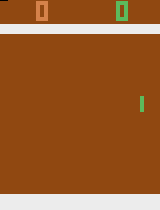

In [16]:
# First match Random agent (green) x Atari (orange)
from IPython.display import Image as gif
gif(open('/content/gifs/game_b.gif','rb').read())

# DQN Network

In [17]:
def diff_transform_matrix(num_frames):
    assert isinstance(num_frames, int) and num_frames >= 1
    s = np.diag(np.power(-1, np.arange(num_frames)))  # alternating sign
    m = s.dot(scipy.linalg.pascal(num_frames, kind='upper'))[::-1, ::-1]
    M = K.constant(m, dtype='float32')
    return M

In [18]:
class DQNetwork:
    def __init__(self,
                 name,
                 actions,
                 input_shape,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 minibatch_size=32,
                 dropout_prob=0.1):
        
        # Parameters
        self.name = name
        self.actions = actions  # Size of the network output
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.minibatch_size = minibatch_size  # Size of the training batches
        self.learning_rate = learning_rate  # Learning rate
        self.dropout_prob = dropout_prob  # Probability of dropout
        
        def diff_transform(S):
            S = K.cast(S, 'float32') / 255
            M = diff_transform_matrix(num_frames=3)
            return K.dot(S, M)
        
        
        S = keras.Input(name='S', shape=input_shape, dtype='uint8')
        # Lambda Layer
        lambda_layer = Lambda(diff_transform)(S)
        # Conv2D Layers
        conv_layer_1 = Conv2D(filters=16, kernel_size=8, strides=4, activation='relu')(lambda_layer)
        conv_layer_2 = Conv2D(filters=32, kernel_size=4, strides=2, activation='relu')(conv_layer_1)
        # Flatten
        flatten_layer = Flatten()(conv_layer_2)
        # Dense Layer
        X = Dense(units=256, activation='relu')(flatten_layer)
        # Output Layer
        Q = keras.layers.Dense(units=actions,
                               activation='linear',
                               kernel_initializer='zeros',
                               name='Q')(X)
        self.model = keras.Model(inputs=S, outputs=Q)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='huber_loss')
    
    
    def train(self, batch, DQN_target):
        """
        Generates inputs and targets from the given batch, trains the model on
        them.
        
        batch: iterable of dictionaries with keys 'state', 'action',
        'next_state', 'reward', 'final'
        DQN_target: a target model to generate targets
        """
        
        States = [datapoint['state'] for datapoint in batch]
        Next_States = [datapoint['next_state'] for datapoint in batch]
        Q_train = []
        
        # Apply DQN and DQN_target to every datapoint simultaneously to reduce computation time
        Current_States_Q_Values = self.model(tf.concat(States,axis=0)).numpy()   # Current States
        Next_States_Q_Values = DQN_target(tf.concat(Next_States,axis=0)).numpy() # Next States
        Next_States_Max_Q_Values = np.max(Next_States_Q_Values,axis=1)           # Max Q Values
        
        # Build Q_train targets
        for i in range(0,len(batch)):
            datapoint = batch[i]
            # The error must be 0 on all actions except the one taken
            y = list(Current_States_Q_Values[i,:])
            if datapoint['final']:
                y[datapoint['action']] = datapoint['reward']
            else:
                y[datapoint['action']] = datapoint['reward'] + \
                                         self.discount_factor * Next_States_Max_Q_Values[i]
            Q_train.append(y)
            

        # Prepare inputs and targets
        S_train = np.asarray(States).squeeze()
        Q_train = np.asarray(Q_train).squeeze()
        
        
        # Train the model for one epoch
        self.model.train_on_batch(S_train,
                                  Q_train)
        
    
    
    def predict(self, state):
        """
        Feeds state to the model, returns predicted Q-values.
        state: a numpy.array with same shape as the network's input
        
        :return: numpy.array with predicted Q-values
        """
        return self.model.predict(state, batch_size=1)
    
    
    def save(self):
        """
        Saves the model weights to disk.
        :param filename: file to which save the weights (must end with ".h5")
        :param append: suffix to append after "model" in the default filename
            if no filename is given
        """
        self.model.save(self.name)

    def load(self):
        self.model.load_weights(self.name)

# DQAgent

In [19]:
class DQAgent:
    def __init__(self,
                 actions,
                 network_input_shape=(4, 110, 84),
                 replay_memory_size=1024,
                 minibatch_size=32,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 dropout_prob=0.1,
                 epsilon=1,
                 epsilon_decrease_rate=9e-7,
                 min_epsilon=0.1):
        
        # Parameters
        self.actions = actions  # Size of the discrete action space
        self.network_input_shape = network_input_shape  # Shape of the DQN input
        self.replay_memory_size = replay_memory_size  # Size of replay memory
        self.minibatch_size = minibatch_size  # Size of a DQN minibatch
        self.learning_rate = learning_rate  # Learning rate for the DQN
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.dropout_prob = dropout_prob  # Dropout probability of the DQN
        self.epsilon = epsilon  # Probability of taking a random action
        self.epsilon_decrease_rate = epsilon_decrease_rate  # See update_epsilon
        self.min_epsilon = min_epsilon  # Minimum value for epsilon
        
        # Replay memory
        self.experience_replay = []
        self.training_count = 0
        
        # Instantiate the deep Q-networks
        # Main DQN
        self.DQN = DQNetwork(
            'DQN',
            self.actions,
            self.network_input_shape,
            learning_rate=self.learning_rate,
            discount_factor=self.discount_factor,
            minibatch_size=self.minibatch_size,
            dropout_prob=self.dropout_prob)
        
        # Target DQN used to generate targets
        self.DQN_target = keras.models.clone_model(self.DQN.model)
        self.DQN_target.trainable = False  # exclude from trainable weights
        
    
    
    def get_action(self, state, training=True, random_action=False):
        """
        Polls DQN for Q-values. Returns argmax(Q) with probability 1-epsilon
        during training, 0 during testing.
        
        state: a state that can be passed as input to DQN
        training: whether to use the current epsilon or return greedy action
        random_action: whether to sample a random action regardless of parameters
        
        :return: the index of (action associated to) the highest Q-value 
        """

        is_random = (random() < self.epsilon) if training else False
        if random_action or is_random:
            return randint(0, self.actions - 1)
        else:
            q_values = self.DQN.predict(state)
            return np.argmax(q_values)
        
    
    
    def get_max_q(self, state):
        """
        Returns the action corresponding to maximum Q value predicted on the given state.
        :param state: a state that can be passed as input to DQN
        :return: an action index corresponding to the maximum Q-value in the 
            given state
        """
        q_values = self.DQN.predict(state)
        idxs = np.argwhere(q_values == np.max(q_values)).ravel()
        return np.random.choice(idxs)
    
    
    def get_random_state(self):
        """
        Samples a random state from the replay memory.
        :return: the sampled state
        """
        return self.experience_replay[randrange(0, len(self.experience_replay))]['state']
    
    
    def add_experience(self, state, action, reward, next_state, final):
        """
        Add a SARS' tuple to the experience replay.
        :param state: current state
        :param action: action index
        :param reward: reward associated to the transition
        :param next_state: next state
        :param final: whether the state is absorbing
        """

        if len(self.experience_replay) >= self.replay_memory_size:
          self.experience_replay.pop(0)

        self.experience_replay.append({'state': state,
                                       'action': action,
                                       'reward': reward,
                                       'next_state': next_state,
                                       'final': final})
    
    
    def sample_batch(self):
        """
        Samples self.minibatch_size random transitions from the replay memory
        and returns them as a batch.
        :return: a batch of SARS' tuples
        """
        batch = []
        
        for i in range(self.minibatch_size):
            batch.append(self.experience_replay[randrange(0, len(self.experience_replay))])

        return np.asarray(batch)
    
    
    def train(self):
        """
        Trains the DQN on a minibatch of transitions.
        """
        self.training_count += 1
#        print ('Training session #%d - epsilon: %f' % \
#              (self.training_count, self.epsilon))
        batch = self.sample_batch()
        
        self.DQN.train(batch, self.DQN_target)  # Train the DQN
    
    
    def update_epsilon(self):
        """
        Decreases the probability of picking a random action, to improve
        exploitation.
        """
        if self.epsilon - self.epsilon_decrease_rate > self.min_epsilon:
            self.epsilon -= self.epsilon_decrease_rate
        else:
            self.epsilon = self.min_epsilon
    
    
    def sync_target_network(self):
        """
        Updates the target DQN with the current weights of the main DQN.
        """
        print('Synchronizing Target Network')
        self.DQN_target.set_weights(self.DQN.model.get_weights())
    
    
    def save_networks(self):
        """
        Saves DQN and DQN_target.
        """
        self.DQN.save()
        self.DQN_target.save()

    def load_weights(self):
        self.DQN.load()

In [20]:
# Create Agent
DQA = DQAgent(env.action_space.n,
              network_input_shape=NET_INPUT_SHAPE,
              replay_memory_size=EXPERIENCE_REPLAY_SIZE,
              minibatch_size=MINIBATCH_SIZE,
              learning_rate=LEARNING_RATE,
              discount_factor=DISCOUNT_FACTOR,
              dropout_prob=DROPOUT_PROB,
              epsilon=INITIAL_EPSILON,
              epsilon_decrease_rate=EPSILON_DECREASE_RATE,
              min_epsilon=MIN_EPSILON)

# GIF Auxiliar function

In [21]:
def generate_gif_from_agent(env, agent, episode_index, resize_to=None, duration=50):
    """
    Store a gif from the episode frames.
    Parameters
    ----------
    env : gym environment
        The environment to record from.
    agent : DQAgent object
        The agent with policy that is used to take actions.
    episode_index : int
        Episode Index (used only to name the gif)
    resize_to : tuple of ints, optional
        The size of the output frames, ``(width, height)``. Notice the
        ordering: first **width**, then **height**. This is the convention PIL
        uses.
    duration : float, optional
        Time between frames in the animated gif, in milliseconds.
    """
    
    print('Generating GIF')

    filepath = 'gifs/ep{:06d}.gif'.format(episode_index)

    # collect frames
    frames = []
    s = env.reset()
    for t in range(env.spec.max_episode_steps or 10000):
        a = agent.get_action(np.asarray([s]), training=False)
        s_next, r, done, info = env.step(a)

        # store frame
        frame = env.render(mode='rgb_array')
        frame = Image.fromarray(frame)
        frame = frame.convert('P', palette=Image.ADAPTIVE)
        if resize_to is not None:
            if not (isinstance(resize_to, tuple) and len(resize_to) == 2):
                raise TypeError("expected a tuple of size 2, resize_to=(w, h)")
            frame = frame.resize(resize_to)

        frames.append(frame)

        if done:
            break

        s = s_next

    # store last frame
    frame = env.render(mode='rgb_array')
    frame = Image.fromarray(frame)
    frame = frame.convert('P', palette=Image.ADAPTIVE)
    if resize_to is not None:
        frame = frame.resize(resize_to)
    frames.append(frame)

    # generate gif
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    frames[0].save(
        fp=filepath, format='GIF', append_images=frames[1:], save_all=True,
        duration=duration, loop=0)

In [22]:
def plot_scores(scores_list):
    plt.style.use('fivethirtyeight')

    fig = plt.figure()
    ax = fig.gca()
    ax.plot(scores_list)
    fig.suptitle('Training Scores', fontsize=16)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Score = $ \sum R_t $')


# Agent Training

In [ ]:
# Set counters
episode = 1
frame_counter = 0
scores_list = []

# Main loop
while episode < MAX_EPISODES:
    # Start episode
    print('-------------------------------------------------')
    print('Episode: ' + str(episode))
    score = 0
    
    # Initialize first state
    current_state = env.reset()
    
    # Main episode loop
    t = 0
    frame_counter += 1
    while t < MAX_TIMESTEPS_PER_EPISODE:
        # Render the game
        if RENDER_VIDEO:
            env.render()
        
        # Select an action using the DQA
        action = DQA.get_action(np.asarray([current_state]))

        # Observe reward and next state
        next_state, reward, done, info = env.step(action)
        frame_counter += 1

        # Store transition in replay memory
        #clipped_reward = np.clip(reward, -1, 1)  # Clip the reward
        DQA.add_experience(np.asarray([current_state]),
                           action,
                           reward,
                           np.asarray([next_state]),
                           done)
        
        # Train the agent
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.train()
            # Every C DQN updates, update DQN_target
            if DQA.training_count % TARGET_NETWORK_UPDATE_FREQ == 0 and DQA.training_count >= TARGET_NETWORK_UPDATE_FREQ:
                DQA.sync_target_network()
        
        # Linear epsilon annealing
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.update_epsilon()

        # Update the current state and score
        current_state = next_state
        score += reward

        # Check end of episode
        if done:
            scores_list.append(score)
            print("Length: %d; Score: %d" % (t + 1, score))
            print("Epsilon = " + str(DQA.epsilon))
            print("Total Frame Counter = " + str(frame_counter))
            break
        
        # Increment Episode Timestep
        t += 1
    
    
    # Save GIF with greedy policy
    if (score > 3):
        generate_gif_from_agent(env=env,
                                agent=DQA,
                                episode_index=episode,
                                resize_to=(320, 420))
    # Increment Episode counter
    episode += 1

-------------------------------------------------
Episode: 20
Length: 1032; Score: -18
Epsilon = 1
Total Frame Counter = 1033
-------------------------------------------------
Episode: 21
Length: 824; Score: -21
Epsilon = 1
Total Frame Counter = 1858
-------------------------------------------------
Episode: 22
Length: 1102; Score: -19
Epsilon = 1
Total Frame Counter = 2961
-------------------------------------------------
Episode: 23
Length: 950; Score: -21
Epsilon = 1
Total Frame Counter = 3912
-------------------------------------------------
Episode: 24
Length: 792; Score: -21
Epsilon = 1
Total Frame Counter = 4705
-------------------------------------------------
Episode: 25
Length: 852; Score: -21
Epsilon = 1
Total Frame Counter = 5558
-------------------------------------------------
Episode: 26
Length: 940; Score: -21
Epsilon = 1
Total Frame Counter = 6499
-------------------------------------------------
Episode: 27
Length: 824; Score: -21
Epsilon = 1
Total Frame Counter = 732

In [ ]:
plot_scores(scores_list)

In [ ]:
gif(open('/content/gifs/ep000200.gif','rb').read())